In [1]:
#Необходимые библиотеки
import warnings;
warnings.filterwarnings('ignore');

import pandas as pd
import numpy as np
from mpl_finance import candlestick2_ohlc
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from numpy.random import seed
from numpy.random import randn
from scipy.stats import ttest_ind

/Users/aleksandrbojko/anaconda3/lib/python3.6/site-packages/mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


Первым делом необходимо преобразовать данные в формат, который совместим с пандасом. Произведем эти преобразования руками в Excel. Теперь имеем 4 датасета по каждому индексу отдельно. 

Для более удобной работы преобразуем их в соответсвущий формат и проведем минимальный препроцессинг. А именно, заменим разделяющую запятую на точку, как приянто мировым стандартом, приведем к нужным форматам данных (float, datatime). Все это реализуем в функции **read_and_preproc_data**

In [2]:
def read_and_preproc_data(PATH):
    data = pd.read_csv(PATH, sep=';')
    
    
    if data['Open'].dtype == object:
        data['Open'] = data['Open'].apply(lambda x: x.replace(',', '.')).astype(float)
        data['Close'] = data['Close'].apply(lambda x: x.replace(',', '.')).astype(float)
        data['High'] = data['High'].apply(lambda x: x.replace(',', '.')).astype(float)
        data['Low'] = data['Low'].apply(lambda x: x.replace(',', '.')).astype(float)
        data['Volume'] = data['Volume'].astype(float)
        
    data['Dates'] = pd.to_datetime(data['Dates'])
    
    data['Date'] = data['Dates'].apply(lambda x: x.date())
    data['Time'] = data['Dates'].apply(lambda x: x.time())
    
    print('shape {}: {}'.format(PATH.split('/')[1].split('.')[0], data.shape ))
    display(data.head(5))
    print()
    
    return data
        

In [3]:
#Считываем и препроцессим данные
sap = read_and_preproc_data('data/S&P.csv')
hsc = read_and_preproc_data('data/Hang_Sang_China.csv')
nikkei = read_and_preproc_data('data/Nikkei.csv')

shape S&P: (2906, 8)


,Dates,Open,Close,High,Low,Volume,Date,Time
0,2020-01-01 22:00:00,3237.00,3237.50,3240.75,3234.25,16226.0,2020-01-01,22:00:00
1,2020-01-01 23:00:00,3237.75,3239.00,3239.25,3237.00,5322.0,2020-01-01,23:00:00
2,2020-02-01 00:00:00,3239.25,3238.25,3240.50,3236.00,11106.0,2020-02-01,00:00:00
3,2020-02-01 01:00:00,3238.50,3239.50,3240.00,3238.00,5068.0,2020-02-01,01:00:00
4,2020-02-01 02:00:00,3239.25,3240.50,3241.00,3239.25,3566.0,2020-02-01,02:00:00



shape Hang_Sang_China: (2277, 8)


,Dates,Open,Close,High,Low,Volume,Date,Time
0,2020-01-01 23:15:00,11251,11263,11263,11251,140,2020-01-01,23:15:00
1,2020-02-01 00:15:00,11265,11331,11336,11193,17829,2020-02-01,00:15:00
2,2020-02-01 01:15:00,11332,11342,11365,11322,8895,2020-02-01,01:15:00
3,2020-02-01 02:15:00,11341,11327,11343,11310,3215,2020-02-01,02:15:00
4,2020-02-01 03:15:00,11335,11299,11335,11298,1682,2020-02-01,03:15:00



shape Nikkei: (2487, 8)


,Dates,Open,Close,High,Low,Volume,Date,Time
0,2020-05-01 22:30:00,23190,23210,23320,23170,18834,2020-05-01,22:30:00
1,2020-05-01 23:30:00,23210,23190,23230,23180,8035,2020-05-01,23:30:00
2,2020-06-01 00:30:00,23190,23140,23200,23110,7634,2020-06-01,00:30:00
3,2020-06-01 01:30:00,23140,23150,23150,23110,3716,2020-06-01,01:30:00
4,2020-06-01 02:30:00,23150,23200,23210,23140,5527,2020-06-01,02:30:00


Для наглядности выведим торговые графики 3-х основных индексов: S&P, HSC, Nikkei соответсвенно. 

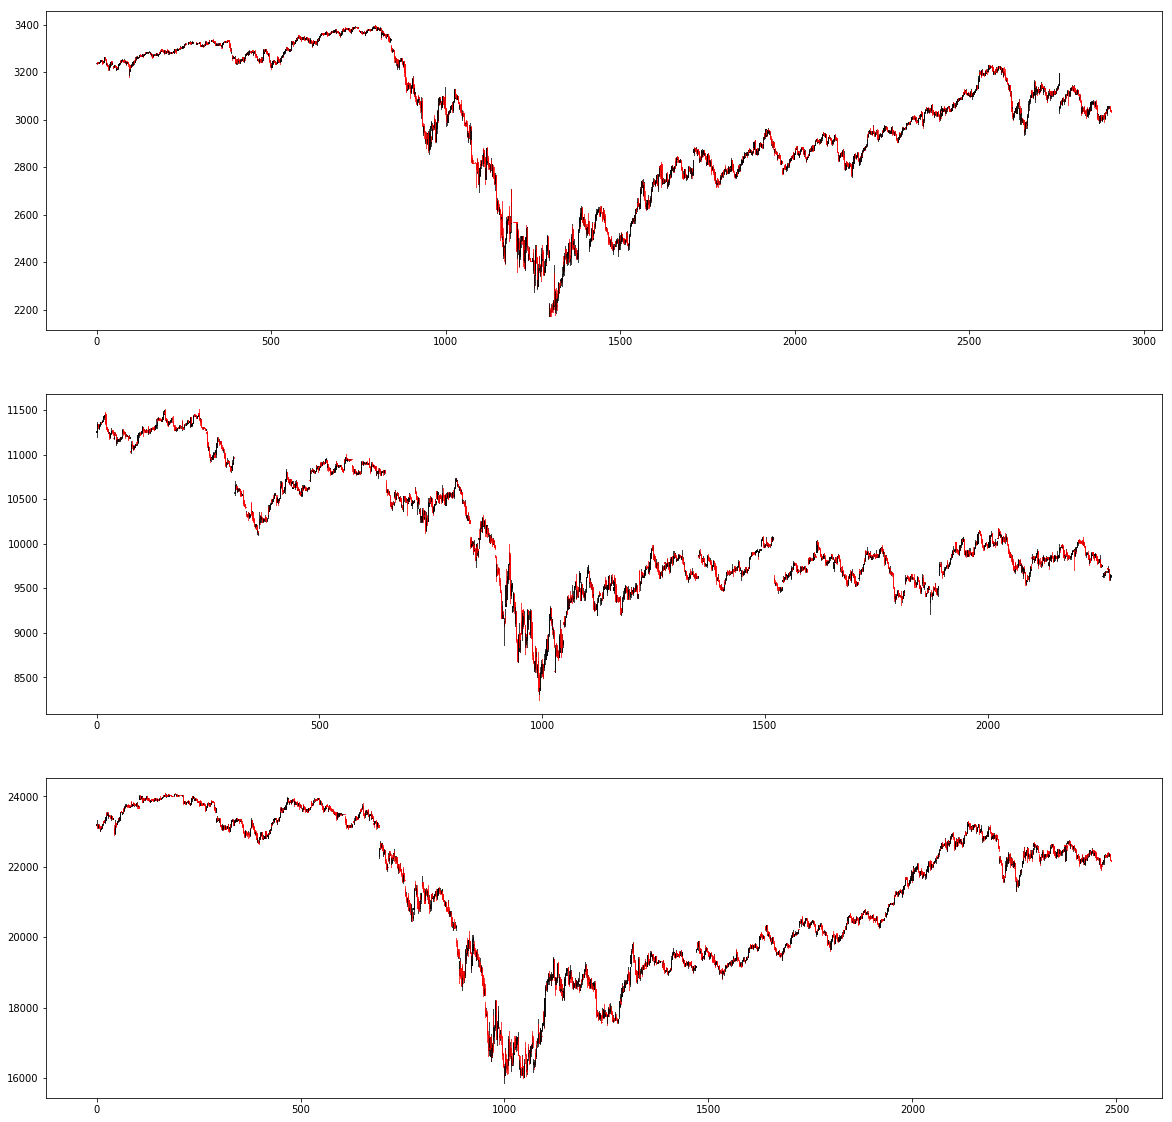

In [4]:
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
candlestick2_ohlc(ax[0], sap['Open'],sap['High'],sap['Low'],sap['Close'],width=0.6)
candlestick2_ohlc(ax[1], hsc['Open'],hsc['High'],hsc['Low'],hsc['Close'],width=0.6)
candlestick2_ohlc(ax[2], nikkei['Open'],nikkei['High'],nikkei['Low'],nikkei['Close'],width=0.6)
plt.show()

Приступим к тестированию гипотез.

## Гипотеза 1. 
### Провека связи уровня волатильности азиатских индексов на закрытии бирж азии и уровня волатильности S&P на открытии американского рынка

Для начала определеим временные рамки в данной задаче. Так как все времена приведены к единому формату UTC. Остается понять время работы американских и азиатских бирж. Для это построим схематичный график

<img src="img/sap_hsc_nikkei.jpg" width=600 height=600 />

Заметим, что Нью-Йоркская фондовая биржа имеет переход на летнее время, он происходит 8.03 в 2 часа ночи. Летом биржа работает с 13 часов по UTC, а зимой с 14 по UTC. Это важно учесть в задаче, потому что необходимо точно знать время открытия.

Для проверки гипотезы, понадобятся некоторые вспомогательные **функции**, которые мы реализуем сами.

**filter_time** -- фильтрует датасет по времени, оставляю только указанные промежутки времени. Необходима для формирования базового объекта исследования.

**calc_volatility_hour** -- расчитывает волатильности одно часа. В формальном виде волатильности высчитывается как:

$$\sigma_{T} = \frac{\sigma_{SD}}{\sqrt{P}},\ where \ P = \frac{1}{252}$$

но в нашем случае это просто $\sqrt{\sigma}$ потому что высчитывается волатильность одного часа. Стоит разу заметить, что волатильность дает более точную оценку ценной бумаге или другому инструменту при более долгих промежутках времени.

In [5]:
def filter_time(data, hour_start, minute_start, hour_end, minute_end, tick):
    one_close = data[(data['Time'] >= pd.Timestamp(year=2020, day=12, month=1, 
                                                               hour=hour_start, minute=minute_start).time()) &
                            (data['Time'] <= pd.Timestamp(year=2020, day=12, month=1, 
                                                            hour=hour_end, minute=minute_end).time())]
    
    one_close = one_close.reset_index(drop=True)
    drop_data = one_close['Date'].value_counts()[one_close['Date'].value_counts() <= tick].index.values
    for i in (drop_data):
        one_close = one_close[one_close['Date'] != i]
        
    one_close = one_close.reset_index(drop=True)
    
    return one_close
    

def calc_volatility_hour(data, w, opn=False):
    dt = []
    vol = []

    start = 0
    end = w

    while end < data.shape[0]:
        d = data.iloc[start:end]
        dt.append(d['Date'].values[0])
        if opn == True:
            price = []
            price.append(d['Open'].iloc[0])
            price.extend(d['Close'].iloc[1:].values)
            vol.append(np.std(price))
        else:
            vol.append(d['Close'].std())

        start += w
        end += w

    df = pd.DataFrame(dt, columns=['Date'])
    df['Volatility'] = vol
    
    return df


def ttest_corr(coef_corr, dof):
    return (np.sqrt(dof - 2) / np.sqrt(1 - (coef_corr**2))) * coef_corr
    

In [6]:
# в данных присутствует как зимний промежуток времени, так и летний. Их необходимо разделить для корректного подсчета
sap_winter = sap[sap['Dates'] <= '2020-03-07'].reset_index(drop=True)
sap_summer = sap[sap['Dates'] > '2020-03-07'].reset_index(drop=True)

Первым делом берем час перед закрытием китайской биржи, на которой торуется Hang Seng и посчитываем волатильности каждого наблюдения. Затем после небольшого препроцессинга S&P, расчитываем волатильности на первом часу после открытия американской биржи.

По получившимся графикам особо ничего не понятно. Кроме того, что китайский индекс более волатильный, чем американский.

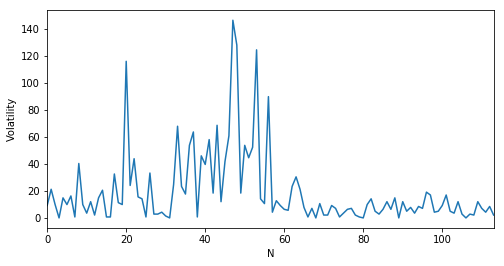

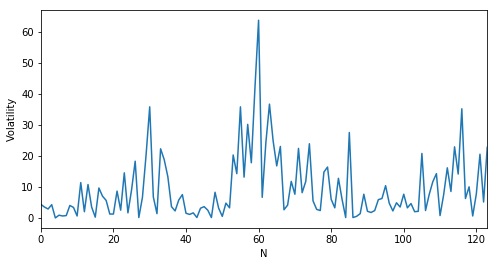

In [7]:
hsc_1hour = filter_time(hsc, 7, 15, 8, 15, tick=1)
hsc_1hour_vol = calc_volatility_hour(hsc_1hour, w=2)

plt.figure(figsize=(8, 4))
plt.xlabel('N')
plt.ylabel('Volatility')
hsc_1hour_vol['Volatility'].plot()
plt.show()

sap_1hour_w = filter_time(sap_winter, 14, 0, 15, 0, tick=1)
sap_1hour_s = filter_time(sap_summer, 13, 0, 14, 0, tick=1)
sap_1hour = pd.concat([sap_1hour_w, sap_1hour_s], axis=0).reset_index(drop=True)

sap_1hour_vol = calc_volatility_hour(sap_1hour, w=2, opn=True)

plt.figure(figsize=(8, 4))
sap_1hour_vol['Volatility'].plot()
plt.xlabel('N')
plt.ylabel('Volatility')
plt.show()

In [8]:
vol_sap_hsc = pd.merge(sap_1hour_vol, hsc_1hour_vol, on='Date', how='inner')
vol_sap_hsc.columns = ['Date', 'Volatility_S&P', 'Volatility_HSC']

Для определения зависимости между двумя волатильностями индексов, мной была выбрана величина **корреляция**.


**Корреляционная зависимость** — статистическая взаимосвязь двух или более случайных величин

В формальном виде корреляция записывается следующим образом:

$$corr(\xi, \eta) = \frac{cov(\xi, \eta)}{\sqrt{D\xi}\sqrt{D\eta}}$$

$$cov(\xi, \eta) = E((\xi - E\xi)(\eta - E\eta))$$

$$corr(\xi, \eta) = \frac{E((\xi - E\xi)(\eta - E\eta))}{\sqrt{D\xi}\sqrt{D\eta}}$$

Тогда пусть, $\xi$ волатильность S&P, а $\eta$ волатильности HSC

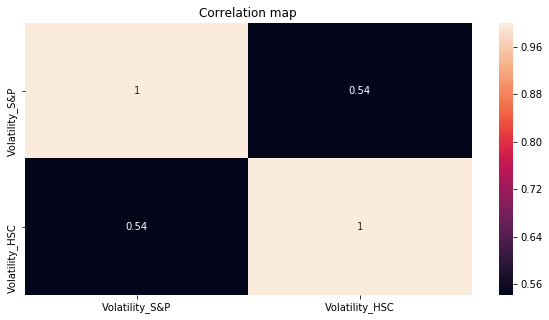

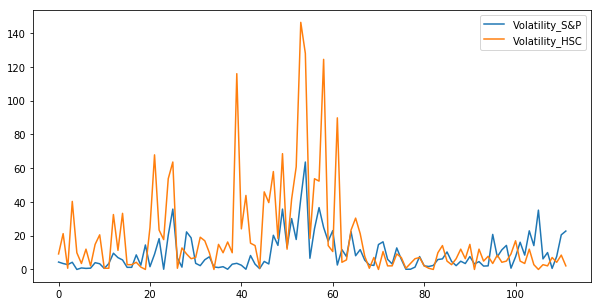

In [9]:
plt.figure(figsize=(10, 5))
plt.title('Correlation map')
sns.heatmap(vol_sap_hsc.corr(), annot=True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(vol_sap_hsc['Volatility_S&P'])
plt.plot(vol_sap_hsc['Volatility_HSC'])
plt.legend()
plt.show()

Получили корреляцию 0.54. Как минимум можно сказать, что она положительная и она есть. Но этого недостаточно, чтобы понять можно ли считать ее важной для данной гипотезы. Для определения этого проверим **гипотезу о существенности корреляционной связи**.


В данном случае при уровне значимостиaнужно проверить гипотезу **Н0: r = 0.** (Если коэффициент корреляции равен нулю, то соответствующие величины не связаны друг с другом). Статистикой в данном случае служит случайная величина:

$$T = r\cdot \frac{\sqrt{(n-2)}}{\sqrt{(1-r^2)}}$$ имеющая распределение Стьюдента с f = n – 2 числом степеней свободы.

Для более удобного использования этот тест был реализван мной в функции **ttest_corr**, которая находится выше.

Затем, получившееся значение, нужно сравнить с таблицей ниже и есть $T_{наблд} > T_{табл}$, то гипотеза отвергается и корреляция является значимой

<img src="img/ttest_corr.png" width=400 height=200 />

In [10]:
ttest_corr(coef_corr=0.54, dof=vol_sap_hsc.shape[0]) > 1.980

True

Получаем **положительный ответ**. Да, действительно, корреляционная свзять этих двух случайных величин существует. Проанализируем график.

<img src="img/sap_hsc_1h.png" width=600 height=600 />

В красных кругах мы видим явную корреляцию. Когда китайский индекс начинает болтать, после этого идет и "всплеск" S&P, а когда китайский индекс находится во флете, S&P ведет себя спокойно

#### Проведем такие же вычисления только для двух часов до закрытия и двух часов после закрытия

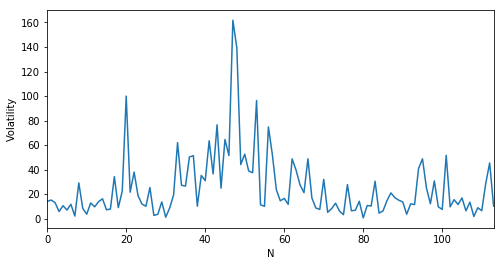

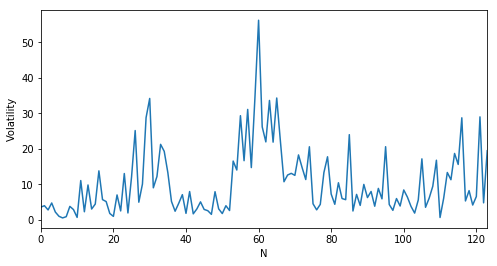

In [11]:
hsc_2hour = filter_time(hsc, 6, 15, 8, 15, tick=2)
hsc_2hour_vol = calc_volatility_hour(hsc_2hour, w=3)

plt.figure(figsize=(8, 4))
hsc_2hour_vol['Volatility'].plot()
plt.xlabel('N')
plt.ylabel('Volatility')
plt.show()

sap_2hour_w = filter_time(sap_winter, 14, 0, 16, 0, tick=2)
sap_2hour_s = filter_time(sap_summer, 13, 0, 15, 0, tick=2)
sap_2hour = pd.concat([sap_2hour_w, sap_2hour_s], axis=0).reset_index(drop=True)

sap_2hour_vol = calc_volatility_hour(sap_2hour, w=3, opn=True)

plt.figure(figsize=(8, 4))
sap_2hour_vol['Volatility'].plot()
plt.xlabel('N')
plt.ylabel('Volatility')
plt.show()

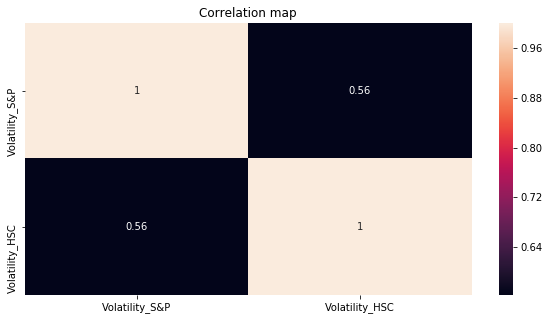

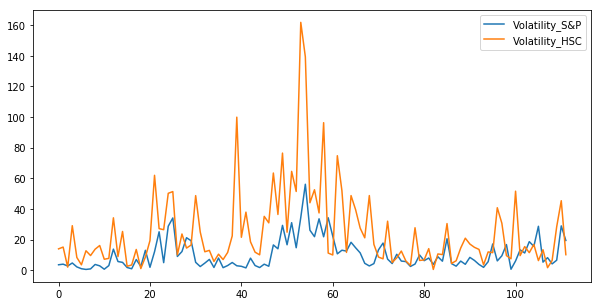

In [12]:
vol_sap_hsc_2hour = pd.merge(sap_2hour_vol, hsc_2hour_vol, on='Date', how='inner')
vol_sap_hsc_2hour.columns = ['Date', 'Volatility_S&P', 'Volatility_HSC']

plt.figure(figsize=(10, 5))
sns.heatmap(vol_sap_hsc_2hour.corr(), annot=True)
plt.title('Correlation map')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(vol_sap_hsc_2hour['Volatility_S&P'])
plt.plot(vol_sap_hsc_2hour['Volatility_HSC'])
plt.legend()
plt.show()

In [13]:
ttest_corr(coef_corr=0.56, dof=vol_sap_hsc_2hour.shape[0]) > 1.980

True

Видим такую же закономерность как и для одно часа, только коэффициент корреляции немного увеличился. **Зависимость есть.**

#### Проведем такой же эксперемент для японского индекса Nikkie

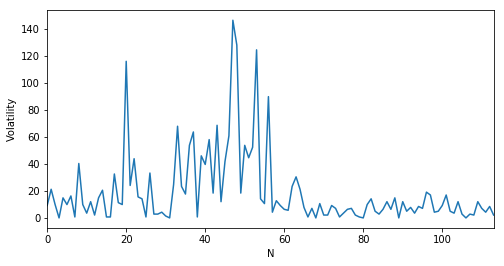

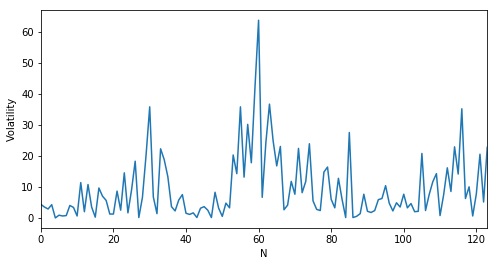

In [14]:
nikkie_filt = nikkei[nikkei['Time'].apply(lambda x: x.hour != 5)].reset_index(drop=True)
nikkie_2hour = filter_time(nikkie_filt, 4, 30, 6, 30, tick=1)
nikkie_2hour_vol = calc_volatility_hour(nikkie_2hour, w=2)

plt.figure(figsize=(8, 4))
hsc_1hour_vol['Volatility'].plot()
plt.xlabel('N')
plt.ylabel('Volatility')
plt.show()

sap_2hour_w = filter_time(sap_winter, 14, 0, 16, 0, tick=2)
sap_2hour_s = filter_time(sap_summer, 13, 0, 15, 0, tick=2)
sap_2hour = pd.concat([sap_2hour_w, sap_2hour_s], axis=0).reset_index(drop=True)

sap_2hour_vol = calc_volatility_hour(sap_1hour, w=3, opn=True)

plt.figure(figsize=(8, 4))
sap_1hour_vol['Volatility'].plot()
plt.xlabel('N')
plt.ylabel('Volatility')
plt.show()

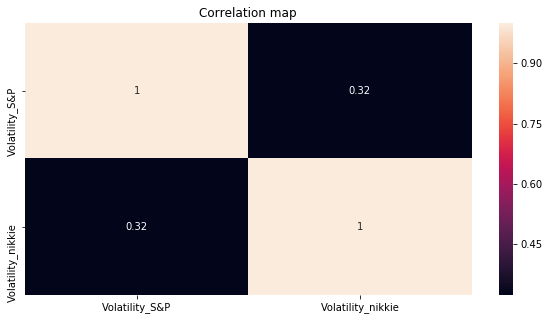

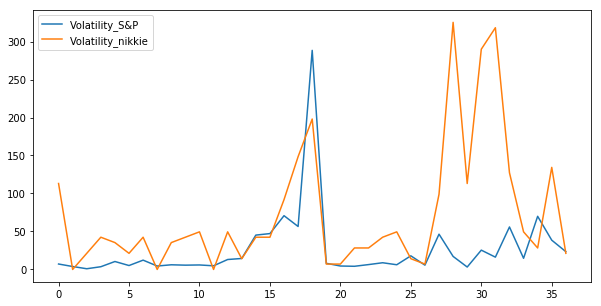

In [15]:
vol_sap_nikkie_2hour = pd.merge(sap_2hour_vol, nikkie_2hour_vol, on='Date', how='inner')
vol_sap_nikkie_2hour.columns = ['Date', 'Volatility_S&P', 'Volatility_nikkie']

plt.figure(figsize=(10, 5))
sns.heatmap(vol_sap_nikkie_2hour.corr(), annot=True)
plt.title('Correlation map')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(vol_sap_nikkie_2hour['Volatility_S&P'])
plt.plot(vol_sap_nikkie_2hour['Volatility_nikkie'])
plt.legend()
plt.show()

In [16]:
ttest_corr(coef_corr=0.52, dof=vol_sap_nikkie_2hour.shape[0]) > 1.980

True

**Корреляция действительно есть**, что подтверждает наш тест на корреляционную зависимость, но она на порядок слабее, чем зависимость от китайского индекса. Поэтому если вопрос стоит какому индексу лучше доверять, то выбор падает на HSC.

## Гипотеза 2.
### Направление движения азиатских индексов на закрытии, как-то влияет на направление движения S&P на открытии американской биржи.

Чтобы проверить данную гипотезу, нужно ввести несколько вспомогательных функций. Но перед этим давайте обговорим каким техническим образом будет проверяться данная гипотеза.

Первым делом мы будем задавать 2-3 точки, в пространстве, строить на них линейную регрессию, затем брать коэффициент угла наклона прямой и таким образом получать резкость тренда. Графически это выглядит примерно так:

<img src="img/linreg.jpg" width=450 height=450 />

Чем больше b тем круче тренд, затем мы получим две случайные величины и проведем корреляционный анализ.

Второе, что было сделано, это биномиальное сравнение, иными словами получим вероятность расти на открытии и вероятность падать, таким образом сможем оценить какой индекс как вероятней себя ведет

Как говорилось выше, нам понадобятся вспомогательные функции.

**direct_price** -- Первое, по сути one hot кодировка цены, где 1 если цена растет и 0 если она падает. Второе, получение резкости тренда, с попомщью линейной регрессии 


**add_trend_feature** -- получение признака угла наклона прямой или гиперплоскости.

In [17]:
from sklearn.linear_model import LinearRegression

def direct_price(data, w, opn=False):
    dt = []
    di = []
    data_trend = []
    trend = []

    start = 0
    end = w

    while end < data.shape[0]:
        d = data.iloc[start:end]
        dt.append(d['Date'].values[0])
        if opn == True:
            if w == 2:
                data_trend.append(d['Open'].iloc[0])
                data_trend.append(d['Close'].iloc[1])
                trend.append(add_trend_feature(data_trend))
                
                if d['Open'].iloc[0] < d['Close'].iloc[1]:
                    di.append(1)
                else:
                    di.append(0)
                    
            elif w == 3:

                data_trend.append(d['Open'].iloc[0])
                data_trend.append(d['Close'].iloc[1])
                data_trend.append(d['Close'].iloc[2])
                trend.append(add_trend_feature(data_trend))
                
                bin_trend = []
                if d['Open'].iloc[0] < d['Close'].iloc[1]:
                    bin_trend.append(1)
                else:
                    bin_trend.append(0)
                if d['Close'].iloc[1] < d['Close'].iloc[2]:
                    bin_trend.append(1)
                else:
                    bin_trend.append(0)
                
                di.append(bin_trend)
                
        else:
            if w == 2:
                data_trend.append(d['Close'].iloc[0])
                data_trend.append(d['Close'].iloc[1])
                trend.append(add_trend_feature(data_trend))
                
                if d['Close'].iloc[0] < d['Close'].iloc[1]:
                    di.append(1)
                else:
                    di.append(0)
            
            elif w == 3:
                data_trend.append(d['Close'].iloc[0])
                data_trend.append(d['Close'].iloc[1])
                data_trend.append(d['Close'].iloc[2])
                trend.append(add_trend_feature(data_trend))

                bin_trend = []
                if d['Close'].iloc[0] < d['Close'].iloc[1]:
                    bin_trend.append(1)
                else:
                    bin_trend.append(0)
                if d['Close'].iloc[1] < d['Close'].iloc[2]:
                    bin_trend.append(1)
                else:
                    bin_trend.append(0)

                di.append(bin_trend)

        start += w
        end += w

    df = pd.DataFrame(dt, columns=['Date'])
    df['Direct'] = di
    df['Trend'] = trend
    
    return df


def add_trend_feature(arr, abs_values=False):
    idx = np.array(range(len(arr)))
    if abs_values:
        arr = np.abs(arr)
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

Протестируем данную гипотезу для 1 часа. Будем сравнивать китайский индекс за час до закрытия и американский час после открытия.

In [18]:
hsc_1hour = filter_time(hsc, 6, 15, 7, 15, tick=1)

sap_1hour_w = filter_time(sap_winter, 14, 0, 15, 0, tick=1)
sap_1hour_s = filter_time(sap_summer, 13, 0, 14, 0, tick=1)
sap_1hour = pd.concat([sap_1hour_w, sap_1hour_s], axis=0).reset_index(drop=True)

In [19]:
sap_dir_1hour = direct_price(sap_1hour, w=2, opn=True)
hsc_dir_1hour = direct_price(hsc_1hour, w=2, opn=True)

In [20]:
dir_sap_hsc_1hour = pd.merge(sap_dir_1hour, hsc_dir_1hour, on='Date', how='inner')
dir_sap_hsc_1hour.columns = ['Date', 'Direct_S&P', 'Trend_S&P','Direct_HSC', 'Trend_HSC']

Видим на графике, что получить отрицательный рост на китайском индексе вероятней, чем на S&P

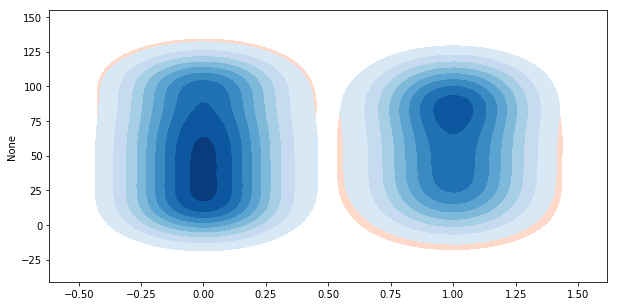

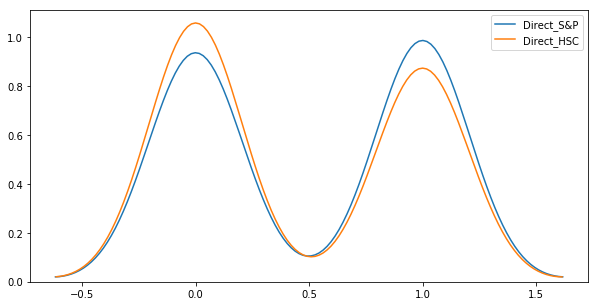

In [21]:
plt.figure(figsize=(10, 5))
sns.kdeplot(dir_sap_hsc_1hour['Direct_S&P'].values, 
            data2=dir_sap_hsc_1hour['Direct_S&P'].index,cmap="Reds", shade=True, shade_lowest=False)

sns.kdeplot(dir_sap_hsc_1hour['Direct_HSC'].values, 
            data2=dir_sap_hsc_1hour['Direct_HSC'].index, cmap="Blues", shade=True, shade_lowest=False)
plt.show()

plt.figure(figsize=(10, 5))
sns.kdeplot(dir_sap_hsc_1hour['Direct_S&P'])
sns.kdeplot(dir_sap_hsc_1hour['Direct_HSC'])
plt.legend()
plt.show()



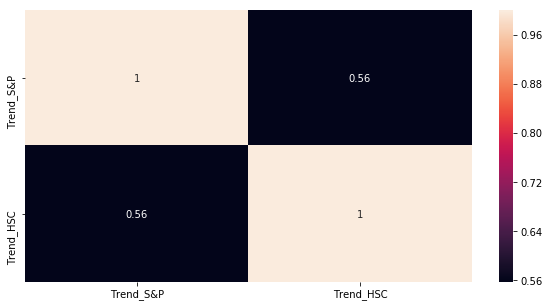

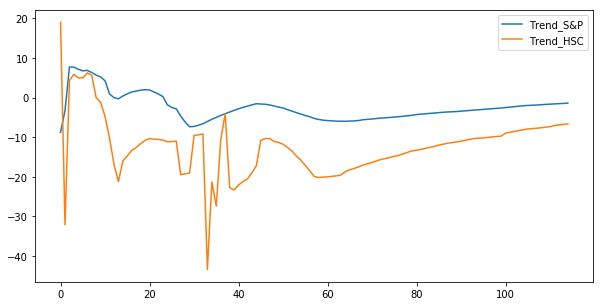

In [22]:
plt.figure(figsize=(10, 5))
sns.heatmap(dir_sap_hsc_1hour[['Trend_S&P', 'Trend_HSC']].corr(), annot=True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(dir_sap_hsc_1hour['Trend_S&P'])
plt.plot(dir_sap_hsc_1hour['Trend_HSC'])
plt.legend()
plt.show()

In [23]:
ttest_corr(coef_corr=0.56, dof=dir_sap_hsc_1hour.shape[0]) > 1.980

True

Видим, что зависимость есть, что подтверждает статистическая проверка гипотез, но есть однин нюанс, который можно заметить на графике.

<img src="img/trend_saphsc_1h.png" width=600 height=600 />

Основная корреляция проявляется именно в красной зоне, это может быть просто совпадение, а сложных корреляций не наблюдается, поэтому эту гипотезу нужно проверить более тчательно, для этого необходимы еще данные

#### Проверим эту же гипотезу для двух часов

In [24]:
hsc_2hour = filter_time(hsc, 5, 15, 7, 15, tick=2)

sap_2hour_w = filter_time(sap_winter, 14, 0, 16, 0, tick=2)
sap_2hour_s = filter_time(sap_summer, 13, 0, 15, 0, tick=2)
sap_2hour = pd.concat([sap_2hour_w, sap_2hour_s], axis=0).reset_index(drop=True)

sap_dir_2hour = direct_price(sap_2hour, w=3, opn=True)
hsc_dir_2hour = direct_price(hsc_2hour, w=3, opn=True)

dir_sap_hsc_2hour = pd.merge(sap_dir_2hour, hsc_dir_2hour, on='Date', how='inner')
dir_sap_hsc_2hour.columns = ['Date', 'Direct_S&P', 'Trend_S&P','Direct_HSC', 'Trend_HSC']

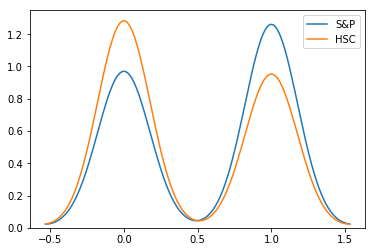

In [25]:
dir_sap = []
dir_hsc = []
for i in range(dir_sap_hsc_2hour.shape[0]):
    ds = dir_sap_hsc_2hour['Direct_S&P'].iloc[i]
    dh = dir_sap_hsc_2hour['Direct_HSC'].iloc[i]
    dir_sap.extend([ds[0], ds[1]])
    dir_hsc.extend([dh[0], dh[1]])
    
sns.kdeplot(dir_sap, label='S&P')
sns.kdeplot(dir_hsc, label='HSC')


На двухчасовом фрейме разница вероятностей проявялется более явно. Достаточно интересный факт, вероятность падения на открытии китайского индекса значительно выше, чем у S&P, это стоти учитывать при построении вероятностой модели. Это еще один интересный факт, который был обнаружен, при проверки основной гипотезы

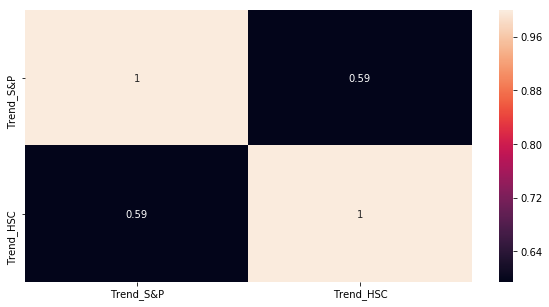

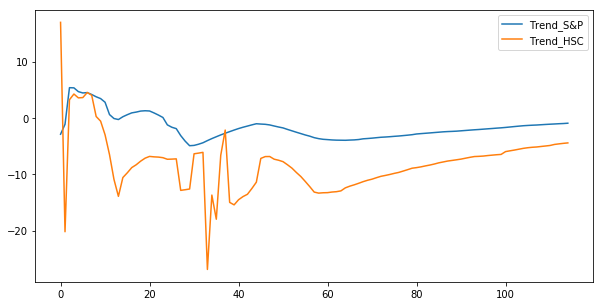

In [26]:
plt.figure(figsize=(10, 5))
sns.heatmap(dir_sap_hsc_2hour[['Trend_S&P', 'Trend_HSC']].corr(), annot=True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(dir_sap_hsc_2hour['Trend_S&P'])
plt.plot(dir_sap_hsc_2hour['Trend_HSC'])
plt.legend()
plt.show()

In [27]:
ttest_corr(coef_corr=0.59, dof=dir_sap_hsc_2hour.shape[0]) > 1.980

True

Коэффициент корреляции незначительно увеличился, но при этом артефакт остался на месте. Хоть статистика говорит о том, что величины явно зависимы, я бы провел еще одну независимую оценку на датасете по больше. Чтоб убедиться в этом.

#### Проверим эту же гипотезу для японсокго индекса.

In [28]:
nikkie_2hour = filter_time(nikkie_filt, 4, 30, 6, 30, tick=1)

sap_2hour_w = filter_time(sap_winter, 14, 0, 16, 0, tick=2)
sap_2hour_s = filter_time(sap_summer, 13, 0, 15, 0, tick=2)
sap_2hour = pd.concat([sap_2hour_w, sap_2hour_s], axis=0).reset_index(drop=True)

sap_dir_2hour = direct_price(sap_2hour, w=3, opn=True)
nikkie_dir_2hour = direct_price(nikkie_2hour, w=2, opn=True)

dir_sap_nikkie_2hour = pd.merge(sap_dir_2hour, nikkie_dir_2hour, on='Date', how='inner')
dir_sap_nikkie_2hour.columns = ['Date', 'Direct_S&P', 'Trend_S&P','Direct_Nikkie', 'Trend_Nikkie']

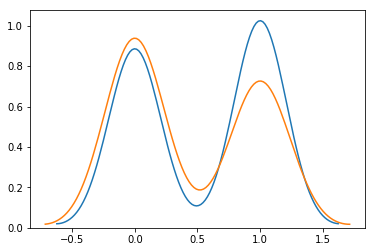

In [29]:
dir_sap = []
dir_nikkie = []
for i in range(dir_sap_nikkie_2hour.shape[0]):
    ds = dir_sap_nikkie_2hour['Direct_S&P'].iloc[i]
    dh = dir_sap_nikkie_2hour['Direct_Nikkie'].iloc[i]
    dir_sap.extend([ds[0], ds[1]])
    dir_nikkie.extend([dh])
    
sns.kdeplot(dir_sap)
sns.kdeplot(dir_nikkie)

Можно заметить, что азиатские индексы открываются с падением гораздо чаще, чем американский, на этом можно сыграть, строя вероятностную модель азиатского рынка

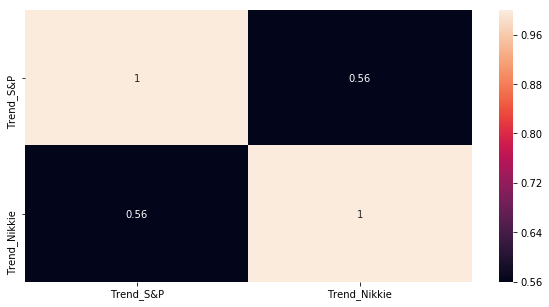

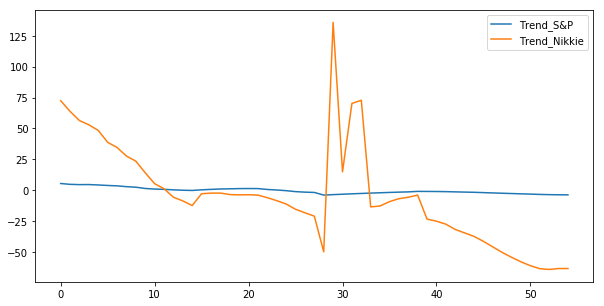

In [30]:
plt.figure(figsize=(10, 5))
sns.heatmap(dir_sap_nikkie_2hour[['Trend_S&P', 'Trend_Nikkie']].corr(), annot=True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(dir_sap_nikkie_2hour['Trend_S&P'])
plt.plot(dir_sap_nikkie_2hour['Trend_Nikkie'])
plt.legend()
plt.show()

In [31]:
ttest_corr(coef_corr=0.56, dof=dir_sap_nikkie_2hour.shape[0]) > 1.980

True

Корреляция есть, но это скорей для спокойного рынка, для трендового анализа нужны еще данные. На данном этапе можно скзаать, что при стабильном рынке у них есть трендовая зависимость, но при коллебаниях, и нестабильных рынках, зависимость сглаживается.

## Гипотеза 3.
### Анализ ретерна на момент открытия американского рынка и закрытия европейского рынка по индексу S&P.

Для начала, по традиции, определим временные рамки.

<img src="img/londonnewyork1.png" width=600 height=600 />

Но при этом также будем учитывать переход на летнее время.

Для начала, определеим как вычисляется ретерн:
    

$$Total\_return = \frac{current\_value - original\_value}{original\_value}$$

Это же было реализовано в функции **return_price**



А вычисление ретерна для определенного промежутка времени реализовано в функции **calc_return_hour**

Для начала, как обычно возьмем промежуток 1 час и проведем корреляционный анализ между ретернами. Где одна случайная величина будет ретерн на открытии, а другая на открытии

In [32]:
def return_price(current_price, original_price):
    return (current_price - original_price) / original_price

 
def calc_return_hour(data, w, opn=False):
    dt = []
    returns = []

    start = 0
    end = w

    while end < data.shape[0]:
        d = data.iloc[start:end]
        dt.append(d['Date'].values[0])
        if opn == True:
            returns.append(return_price(d['Open'].iloc[0], d['Close'].iloc[-1]))
        else:
            returns.append(return_price(d['Close'].iloc[0], d['Close'].iloc[-1]))

        start += w
        end += w

    df = pd.DataFrame(dt, columns=['Date'])
    df['Return'] = returns
    
    return df

In [33]:
sap_1hour_w = filter_time(sap_winter, 14, 0, 15, 0, tick=1)
sap_1hour_s = filter_time(sap_summer, 13, 0, 14, 0, tick=1)
sap_1hour = pd.concat([sap_1hour_w, sap_1hour_s], axis=0).reset_index(drop=True)

sap_1hour_cw = filter_time(sap_winter, 16, 0, 17, 0, tick=1)
sap_1hour_cs = filter_time(sap_summer, 15, 0, 16, 0, tick=1)
sap_1hour_c = pd.concat([sap_1hour_cw, sap_1hour_cs], axis=0).reset_index(drop=True)

return_open = calc_return_hour(sap_1hour, w=2, opn=True)
return_close = calc_return_hour(sap_1hour_c, w=2)

return_sap_1hour = pd.merge(return_open, return_close, on='Date', how='inner')
return_sap_1hour.columns = ['Date', 'Return_open', 'Return_close']

Так как наши ретерны были получены из одного распределения, мы можем их сравнивать. Для начала построим плотности распределений двух случайных величин и сравним статистически 2 распределения.

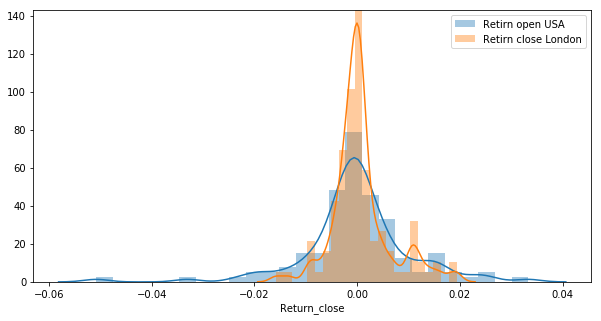

In [34]:
plt.figure(figsize=(10, 5))
sns.distplot(return_sap_1hour['Return_open'], label='Retirn open USA')
sns.distplot(return_sap_1hour['Return_close'], label='Retirn close London')
plt.legend()
plt.show()

**Студенческий т-тест**

Проверим гипотезу:

Не в состоянии отклонить H0: Распределения выборки равны


Отклонить H0: Распределения выборки не равны.

In [35]:
# seed the random number generator
seed(1)
# generate two independent samples
data1 = return_sap_1hour['Return_open']
data2 = return_sap_1hour['Return_close']
# compare samples
stat, p = ttest_ind(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=-0.751, p=0.453
Same distributions (fail to reject H0)


Распределения действительно равны, теперь проведем корреляционный анализ.

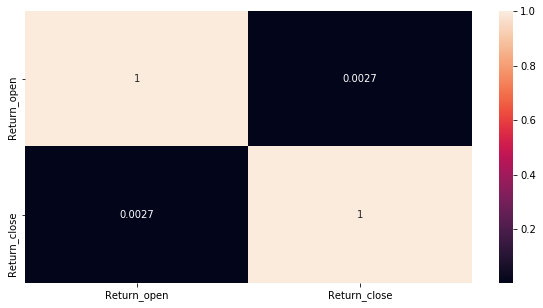

In [36]:
plt.figure(figsize=(10, 5))
sns.heatmap(return_sap_1hour.corr(), annot=True)
plt.show()

In [37]:
ttest_corr(coef_corr=0.0027, dof=return_sap_1hour.shape[0]) > 1.980

False

Корреляция крайне низкая, и статистический критерий ее отвергает, это может означать 2 варианта, либо взят слишком маленький промежуток времени, либо корреляция отсутсвует.

### Возьмем отрезок 2 часа

In [38]:
sap_2hour_w = filter_time(sap_winter, 14, 0, 16, 0, tick=2)
sap_2hour_s = filter_time(sap_summer, 13, 0, 15, 0, tick=2)
sap_2hour = pd.concat([sap_2hour_w, sap_2hour_s], axis=0).reset_index(drop=True)

sap_2hour_cw = filter_time(sap_winter, 15, 0, 17, 0, tick=2)
sap_2hour_cs = filter_time(sap_summer, 14, 0, 16, 0, tick=2)
sap_2hour_c = pd.concat([sap_2hour_cw, sap_2hour_cs], axis=0).reset_index(drop=True)

return_open_2h = calc_return_hour(sap_2hour, w=3, opn=True)
return_close_2h = calc_return_hour(sap_2hour_c, w=3)

return_sap_2hour = pd.merge(return_open_2h, return_close_2h, on='Date', how='inner')
return_sap_2hour.columns = ['Date', 'Return_open', 'Return_close']

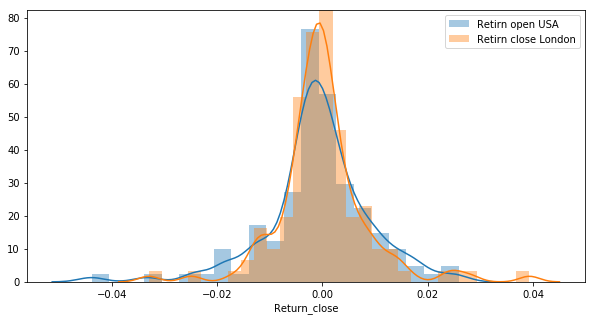

In [39]:
plt.figure(figsize=(10, 5))
sns.distplot(return_sap_2hour['Return_open'], label='Retirn open USA')
sns.distplot(return_sap_2hour['Return_close'], label='Retirn close London')
plt.legend()
plt.show()

In [40]:
# seed the random number generator
seed(1)
# generate two independent samples
data1 = return_sap_2hour['Return_open']
data2 = return_sap_2hour['Return_close']
# compare samples
stat, p = ttest_ind(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=-0.698, p=0.486
Same distributions (fail to reject H0)


Распределения равны, продолжаем анализ

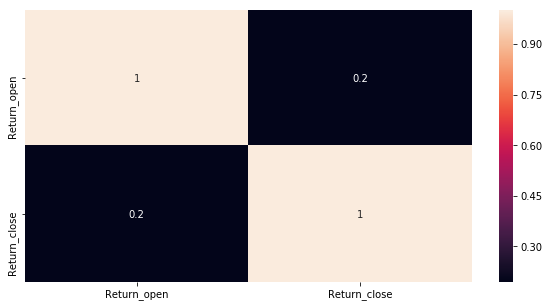

In [41]:
plt.figure(figsize=(10, 5))
sns.heatmap(return_sap_2hour.corr(), annot=True)
plt.show()

In [42]:
ttest_corr(coef_corr=0.2, dof=return_sap_2hour.shape[0]) > 1.980

True

Действительно какая-то корреляция есть, мы ее нашли, и распределения совпадают. Можно искать более сложные зависимости опираясь на новые гипотезы.

Таким образом, был произведен анализ всех гипотез, были выявлены новые зависимости в процессе анализа, по типу вероятнсоти падения у китайского и японского индекса. Остальные гипотезы блыи проверенны и доказаны.

Для связи с кандидатом можно использовать следующие контакты: BoykoA.A@yandex.ru

tel: 89189441133

С уважением, Александр Бойко